In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib

import common.loss_utils as loss_utils

import sys
sys.path.append('metnet')
import metnet

In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
EXPECTED = 24
FORECAST = 10

model = metnet.MetNet(
        hidden_dim=32,
        forecast_steps=FORECAST, # 24 timesteps out
        input_channels=1, # 12 timeteps in
        output_channels=1, # 1 data channel in
        sat_channels=1, # 1 data channel in
        input_size=32, # =128/4, where 128 is the image dimensions
)
print("LOADING 20")
model.load_state_dict(torch.load('metnet_epochs_20.pt'))
model = model.to(DEVICE)

LOADING 20


In [5]:
p = pathlib.Path('climatehack-submission/features.npz')
t = pathlib.Path('climatehack-submission/targets.npz')
feats = np.load(p)
targs = np.load(t)

In [6]:
list(feats.keys()), list(targs.keys())

(['data', 'osgb'], ['data'])

In [7]:
x = feats['data']
y = targs['data']

In [8]:
x.shape, y.shape

((200, 12, 128, 128), (200, 24, 64, 64))

In [9]:
_MAX_PIXEL = 1023
_MEAN = 0.1787

def transform(x):
    return (x / _MAX_PIXEL) - _MEAN

def inv_transform(x):
    return (x + _MEAN) * _MAX_PIXEL

In [10]:
criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)

In [11]:
model.eval()

losses = []
for i, (xi, yi) in enumerate(tqdm.tqdm(zip(x, y), total=len(x))):
    xi = torch.FloatTensor(transform(xi)).to(DEVICE)
    yi = torch.FloatTensor(yi).to(DEVICE)
    
    xi = torch.unsqueeze(xi, dim=0)
    xi = torch.unsqueeze(xi, dim=2)
    with torch.no_grad():
        preds = model(xi)
    
    # remove the batch and satellite channel dimension from the prediction
    preds = torch.squeeze(preds)
    preds = inv_transform(preds)
    
    missing = EXPECTED - FORECAST
    # just do persistence
    missing_pred = inv_transform(xi[:,-1,:,32:96,32:96])
    missing_pred = torch.squeeze(missing_pred)
    missing_pred = torch.tile(missing_pred, (missing, 1, 1))
    # stack them together
    preds = torch.cat([preds, missing_pred], dim=0)

    # OR, just test the ones we did
#     yi = yi[:10]
    
    # also need to do this
    preds = preds.unsqueeze(dim=1)
    yi = yi.unsqueeze(dim=1)
    loss = criterion(preds, yi)
    losses.append(loss.item())

  0%|                                                                                                                            | 0/200 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:48<00:00,  4.09it/s]


In [12]:
np.mean(losses)

0.579194673076272

In [13]:
out = np.squeeze(preds[0].cpu().numpy())

In [14]:
r = np.squeeze(xi[:,-1].cpu().numpy())

In [15]:
y = np.squeeze(yi[:,-1].cpu().numpy())

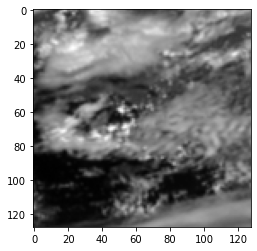

In [16]:
plt.imshow(r, cmap='gray')

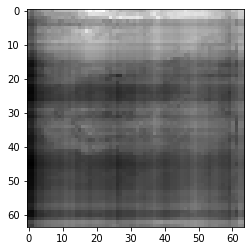

In [17]:
plt.imshow(out, cmap='gray')

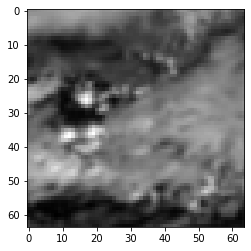

In [18]:
plt.imshow(y[0], cmap='gray')